In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging

import holoviews as hv
import hvplot.polars  # noqa
import neurokit2 as nk
import polars as pl
from polars import col

from src.database.database_manager import DatabaseManager
from src.features.scaling import scale_min_max
from src.features.transforming import merge_dfs
from src.log_config import configure_logging

configure_logging(
    stream_level=logging.DEBUG, ignore_libs=("Comm", "bokeh", "tornado", "matplotlib")
)
logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
db = DatabaseManager()

In [4]:
with db:
    df = db.get_table("Preprocess_eda")
df

17:21:59 | DEBUG   | root | TODO: find criteria for filtering invalid participants in the exclude_invalid_data kw.


trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,eda_raw,eda_tonic,eda_phasic
u16,u8,u8,u32,f64,i64,f64,f64,f64
25,1,3,23654,184809.3687,204865,3.901099,4.468564,-0.567465
25,1,3,23655,184814.3557,204866,3.902564,4.470499,-0.567935
25,1,3,23657,184826.3244,204868,3.902564,4.472437,-0.569873
25,1,3,23658,184837.2969,204869,3.908425,4.474377,-0.565952
25,1,3,23659,184844.2758,204870,3.905495,4.476321,-0.570826
25,1,3,23660,184858.2382,204871,3.911355,4.478267,-0.566912
…,…,…,…,…,…,…,…,…
524,12,45,385904,3.0148e6,502206,35.591274,35.547866,0.150816
524,12,45,385905,3.0148e6,502207,35.627722,35.547865,0.186922


## Comparing neurokit / biopac / highpass filter (0.05 Hz) vs Median smoothing

From the neurokit2 documentation:
  * **High-pass filtering**: Method implemented in Biopac's Acqknowledge. The raw EDA signal
    is passed through a high pass filter with a cutoff frequency of 0.05 Hz
    (cutoff frequency can be adjusted by the ``cutoff`` argument).
  * **Median smoothing**: Method implemented in Biopac's Acqknowledge. The raw EDA signal is
    passed through a median value smoothing filter, which removes areas of rapid change. The
    phasic component is then calculated by subtracting the smoothed signal from the original.
    This method is computationally intensive and the processing time depends on the smoothing
    factor, which can be controlled by the as ``smoothing_factor`` argument, set by default to
    ``4`` seconds. Higher values will produce results more rapidly.

In [5]:
scale_min_max(df).hvplot(
    x="timestamp",
    y=["eda_raw", "eda_phasic", "eda_tonic"],
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'fbd8528f-36be-4d1e-9c59-0af2e3e5693c': {'version…

In [10]:
from scipy.io import savemat

trial = df.filter(col("trial_id") == 81)["eda_raw"].to_numpy().T
savemat("eda_raw_t.mat", {"eda_raw": trial})

In [10]:
from src.features.eda import detrend_tonic_component

df = detrend_tonic_component(df)
df

trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,eda_raw,eda_tonic,eda_phasic,eda_tonic_detrended
u16,u8,u8,u32,f64,i64,f64,f64,f64,f64
25,1,3,23654,184809.3687,204865,3.901099,4.468564,-0.567465,-2.402793
25,1,3,23655,184814.3557,204866,3.902564,4.470499,-0.567935,-2.400858
25,1,3,23657,184826.3244,204868,3.902564,4.472437,-0.569873,-2.39892
25,1,3,23658,184837.2969,204869,3.908425,4.474377,-0.565952,-2.396979
25,1,3,23659,184844.2758,204870,3.905495,4.476321,-0.570826,-2.395035
25,1,3,23660,184858.2382,204871,3.911355,4.478267,-0.566912,-2.393088
…,…,…,…,…,…,…,…,…,…
332,12,28,355476,2.7771e6,467073,13.679468,13.578894,-0.012187,1.382276
332,12,28,355477,2.7771e6,467074,13.679468,13.578894,-0.012765,1.382664


In [ ]:
scale_min_max(df).hvplot(
    x="timestamp",
    y=["eda_raw", "eda_phasic", "eda_tonic", "eda_tonic_detrended"],
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'52b28b7c-e95b-4d26-8e9f-2916d0c5eeee': {'version…

In [ ]:
with db:
    stimulus = db.get_table("Feature_stimulus")

merged = merge_dfs([df, stimulus])
scale_min_max(merged.interpolate()).hvplot(
    x="timestamp",
    y=[
        "eda_tonic",
        "eda_tonic_detrended",
        # "rating",
        "eda_raw",
    ],
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'889af1b7-b11e-4244-bdf2-6a2d8a157a49': {'version…

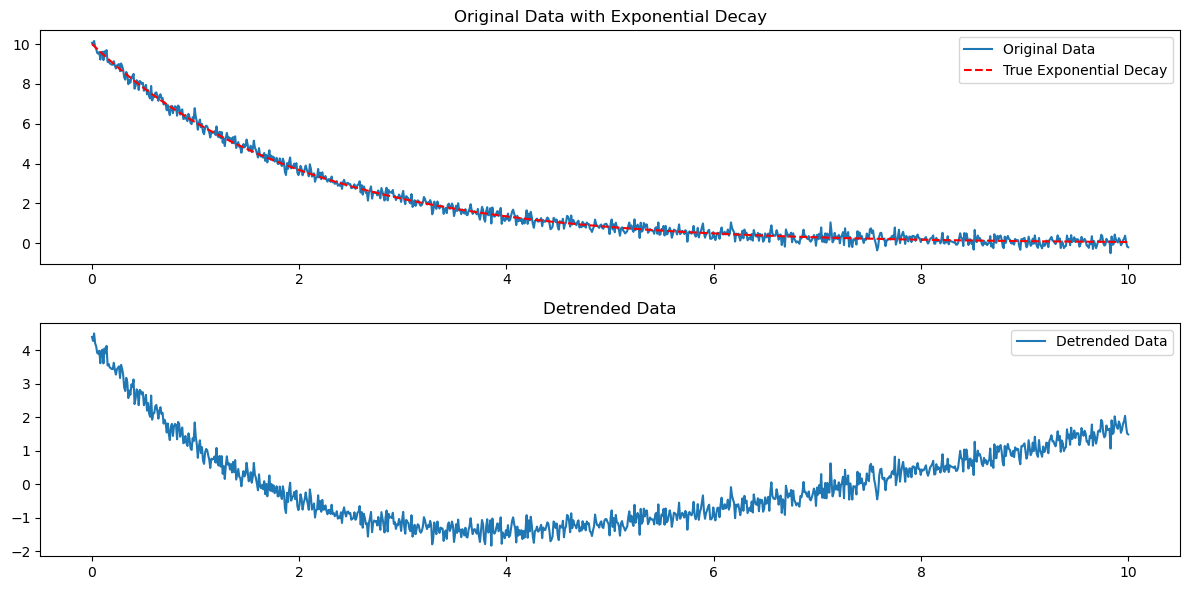

Mean of detrended data: 0.000000
Mean of original data: 1.994548


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


# Generate sample data
def generate_exponential_decay(t, amplitude, decay_rate, noise_level):
    decay = amplitude * np.exp(-decay_rate * t)
    noise = np.random.normal(0, noise_level, len(t))
    return decay + noise


# Set up parameters
t = np.linspace(0, 10, 1000)
amplitude = 10
decay_rate = 0.5
noise_level = 0.2

# Generate synthetic data
data = generate_exponential_decay(t, amplitude, decay_rate, noise_level)

# Detrend the data
detrended_data = signal.detrend(data)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, data, label="Original Data")
plt.plot(t, amplitude * np.exp(-decay_rate * t), "r--", label="True Exponential Decay")
plt.title("Original Data with Exponential Decay")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, detrended_data, label="Detrended Data")
plt.title("Detrended Data")
plt.legend()

plt.tight_layout()
plt.show()

# Calculate and print the mean of the detrended data
print(f"Mean of detrended data: {np.mean(detrended_data):.6f}")
print(f"Mean of original data: {np.mean(data):.6f}")


In [ ]:
from src.database.data_config import DataConfig

DataConfig.load_imotions_config()["PPG"]

{'file_name': 'Shimmer3_EDA_&_PPG_Shimmer3_EDA_&_PPG_ET_Shimmer_ShimmerDevice',
 'load_columns': ['RowNumber',
  'SampleNumber',
  'Timestamp',
  'Internal ADC A13 PPG CAL',
  'Heart Rate PPG ALG',
  'IBI PPG ALG'],
 'rename_columns': {'Internal ADC A13 PPG CAL': 'ppg_raw',
  'Heart Rate PPG ALG': 'PPG_HeartRate',
  'IBI PPG ALG': 'PPG_IBI'},
 'comment': 'same device as EDA'}

In [ ]:
altair,         2.14.0             pyhd8ed1ab_0    conda-forge
beautifulsoup4            6.1.0              pyhd8ed1ab_0    conda-forge
bokeh                    3.0.0              pyhd8ed1ab_0    conda-forge
colorama                5.8               h9397a75_1203    conda-forge
duckdb              4.1.0              pyhd8ed1ab_0    conda-forge
holoviews                 1.19.1             pyhd8ed1ab_0    conda-forge
hpack                   0.27.0             pyhd8ed1ab_0    conda-forge
hvplot                   6.0.1              pyhd8ed1ab_0    conda-forge
icecream            6.4.0              pyhd8ed1ab_0    conda-forge
ipykernel                 6.29.5             pyh57ce528_0    conda-forge
ipython                   8.26.0             pyh707e725_0    conda-forge
ipywidgets                0.19.1             pyhd8ed1ab_0    conda-forge
jinja2         format-nongpl 4.23.0               hd8ed1ab_0    conda-forge
jupyter                   1.0.0             pyhd8ed1ab_10    conda-forge
jupyter-lsp               2.2.5              pyhd8ed1ab_0    conda-forge
jupyter_bokeh             4.0.5              pyhd8ed1ab_0    conda-forge
jupyter_client            1.3.5              pyhd8ed1ab_0    conda-forge
markdown                3.0.2              pyhd8ed1ab_0    conda-forge
mne-base               0.2.9              pyhecae5ae_0    conda-forge
notebook                  7.2.1              pyhd8ed1ab_0    conda-forge
notebook-shim             0.2.4              pyhd8ed1ab_0    conda-forge
numba                     0.60.0          py312h41cea2d_0    conda-forge
numpy                      24.1               pyhd8ed1ab_0    conda-forge
pandas                 4.2.2              pyhd8ed1ab_0    conda-forge
plotly                  1.8.0              pyhd8ed1ab_0    conda-forge
polars                    0.2.2              pyhd8ed1ab_0    conda-forge
pyarrow                  1.1.0              pyhd8ed1ab_0    conda-forge
pyserial                 0.19.0          py312h552d48e_0    conda-forge
scikit-base               0.8.2              pyhecae5ae_0    conda-forge
scikit-learn              1.5.2           py312h387f99c_1    conda-forge
scipy                     1.14.1          py312h20deb59_1    conda-forge
screeninfo                0.8.1           py312h81bd7bf_2    conda-forge
seaborn                   0.13.2               hd8ed1ab_2    conda-forge
seaborn-base              5.2.6                h57fd34a_0    conda-forge
yaml                    

In [ ]:
# Name                    Version                   Build  Channel
absl-py                   2.1.0              pyhd8ed1ab_0    conda-forge
alembic                   1.13.3             pyhd8ed1ab_0    conda-forge
altair                    5.4.1              pyhd8ed1ab_0    conda-forge
anyio                     4.4.0              pyhd8ed1ab_0    conda-forge
appnope                   0.1.4              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py312h02f2b3b_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
aws-c-auth                0.7.22              h8a62e84_10    conda-forge
aws-c-cal                 0.7.1                h94d0942_1    conda-forge
aws-c-common              0.9.23               h99b78c6_0    conda-forge
aws-c-compression         0.2.18               h94d0942_7    conda-forge
aws-c-event-stream        0.4.2               hb74cd8f_15    conda-forge
aws-c-http                0.8.2                had1507a_6    conda-forge
aws-c-io                  0.14.10              hcdb10ff_1    conda-forge
aws-c-mqtt                0.10.4               h856d8ab_8    conda-forge
aws-c-s3                  0.6.0                ha9fd6de_2    conda-forge
aws-c-sdkutils            0.1.16               h94d0942_3    conda-forge
aws-checksums             0.1.18               h94d0942_7    conda-forge
aws-crt-cpp               0.27.3               h9d3339c_2    conda-forge
aws-sdk-cpp               1.11.329             he6360a2_9    conda-forge
azure-core-cpp            1.12.0               hd01fc5c_0    conda-forge
azure-identity-cpp        1.8.0                h0a11218_1    conda-forge
azure-storage-blobs-cpp   12.11.0              h77cc766_1    conda-forge
azure-storage-common-cpp  12.6.0               h7024f69_1    conda-forge
azure-storage-files-datalake-cpp 12.10.0              h64d02d0_1    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge
bleach                    6.1.0              pyhd8ed1ab_0    conda-forge
bokeh                     3.4.2              pyhd8ed1ab_0    conda-forge
bottleneck                1.4.0           py312h755e627_2    conda-forge
brotli                    1.1.0                hb547adb_1    conda-forge
brotli-bin                1.1.0                hb547adb_1    conda-forge
brotli-python             1.1.0           py312h9f69965_1    conda-forge
bzip2                     1.0.8                h99b78c6_7    conda-forge
c-ares                    1.32.2               h99b78c6_0    conda-forge
ca-certificates           2024.8.30            hf0a4a13_0    conda-forge
cachecontrol              0.14.0             pyhd8ed1ab_1    conda-forge
cachecontrol-with-filecache 0.14.0             pyhd8ed1ab_1    conda-forge
cached-property           1.5.2                hd8ed1ab_1    conda-forge
cached_property           1.5.2              pyha770c72_1    conda-forge
certifi                   2024.8.30          pyhd8ed1ab_0    conda-forge
cffi                      1.16.0          py312h8e38eb3_0    conda-forge
charset-normalizer        3.3.2              pyhd8ed1ab_0    conda-forge
cleo                      2.1.0              pyhd8ed1ab_0    conda-forge
click                     8.1.7           unix_pyh707e725_0    conda-forge
cloudpickle               3.0.0              pyhd8ed1ab_0    conda-forge
colorama                  0.4.6              pyhd8ed1ab_0    conda-forge
colorcet                  3.1.0              pyhd8ed1ab_0    conda-forge
colorlog                  6.8.2           py312h81bd7bf_1    conda-forge
comm                      0.2.2              pyhd8ed1ab_0    conda-forge
contourpy                 1.2.1           py312h0fef576_0    conda-forge
crashtest                 0.4.1              pyhd8ed1ab_0    conda-forge
cvxopt                    1.3.2           py312h839f0f8_2    conda-forge
cycler                    0.12.1             pyhd8ed1ab_0    conda-forge
cython                    3.0.10          py312h20a0b95_0    conda-forge
cytoolz                   1.0.0           py312h024a12e_1    conda-forge
dask                      2024.10.0          pyhd8ed1ab_0    conda-forge
dask-core                 2024.10.0          pyhd8ed1ab_0    conda-forge
dask-expr                 1.1.16             pyhd8ed1ab_0    conda-forge
datashader                0.16.3             pyhd8ed1ab_0    conda-forge
debugpy                   1.8.2           py312h5c2e7bc_0    conda-forge
decorator                 5.1.1              pyhd8ed1ab_0    conda-forge
defusedxml                0.7.1              pyhd8ed1ab_0    conda-forge
distlib                   0.3.8              pyhd8ed1ab_0    conda-forge
distributed               2024.10.0          pyhd8ed1ab_0    conda-forge
dsdp                      5.8               h9397a75_1203    conda-forge
duckdb                    1.0.0                hd8ed1ab_0    conda-forge
dulwich                   0.21.7          py312he37b823_0    conda-forge
entrypoints               0.4                pyhd8ed1ab_0    conda-forge
exceptiongroup            1.2.2              pyhd8ed1ab_0    conda-forge
executing                 2.0.1              pyhd8ed1ab_0    conda-forge
expyriment                0.11.dev2                pypi_0    pypi
fftw                      3.3.10          nompi_h6637ab6_110    conda-forge
filelock                  3.15.4             pyhd8ed1ab_0    conda-forge
filterpy                  1.4.5                      py_1    conda-forge
fonttools                 4.53.1          py312h7e5086c_0    conda-forge
fqdn                      1.5.1              pyhd8ed1ab_0    conda-forge
freetype                  2.12.1               hadb7bae_2    conda-forge
fsspec                    2024.6.1           pyhff2d567_0    conda-forge
gflags                    2.2.2             hc88da5d_1004    conda-forge
glog                      0.7.1                heb240a5_0    conda-forge
glpk                      5.0                  h6d7a090_0    conda-forge
gmp                       6.3.0                h7bae524_2    conda-forge
greenlet                  3.1.1           py312hde4cb15_0    conda-forge
grpcio                    1.62.2          py312h17030e7_0    conda-forge
gsl                       2.7                  h6e638da_0    conda-forge
h11                       0.14.0             pyhd8ed1ab_0    conda-forge
h2                        4.1.0              pyhd8ed1ab_0    conda-forge
holoviews                 1.19.1             pyhd8ed1ab_0    conda-forge
hpack                     4.0.0              pyh9f0ad1d_0    conda-forge
httpcore                  1.0.5              pyhd8ed1ab_0    conda-forge
httpx                     0.27.0             pyhd8ed1ab_0    conda-forge
hvplot                    0.10.0             pyhd8ed1ab_0    conda-forge
hyperframe                6.0.1              pyhd8ed1ab_0    conda-forge
icecream                  2.1.3              pyhd8ed1ab_0    conda-forge
icu                       75.1                 hfee45f7_0    conda-forge
idna                      3.7                pyhd8ed1ab_0    conda-forge
importlib-metadata        8.0.0              pyha770c72_0    conda-forge
importlib_metadata        8.0.0                hd8ed1ab_0    conda-forge
importlib_resources       6.4.0              pyhd8ed1ab_0    conda-forge
ipykernel                 6.29.5             pyh57ce528_0    conda-forge
ipython                   8.26.0             pyh707e725_0    conda-forge
ipywidgets                8.1.3              pyhd8ed1ab_0    conda-forge
isoduration               20.11.0            pyhd8ed1ab_0    conda-forge
jaraco.classes            3.4.0              pyhd8ed1ab_1    conda-forge
jedi                      0.19.1             pyhd8ed1ab_0    conda-forge
jinja2                    3.1.4              pyhd8ed1ab_0    conda-forge
joblib                    1.4.2              pyhd8ed1ab_0    conda-forge
json5                     0.9.25             pyhd8ed1ab_0    conda-forge
jsonpointer               3.0.0           py312h81bd7bf_0    conda-forge
jsonschema                4.23.0             pyhd8ed1ab_0    conda-forge
jsonschema-specifications 2023.12.1          pyhd8ed1ab_0    conda-forge
jsonschema-with-format-nongpl 4.23.0               hd8ed1ab_0    conda-forge
jupyter                   1.0.0             pyhd8ed1ab_10    conda-forge
jupyter-lsp               2.2.5              pyhd8ed1ab_0    conda-forge
jupyter_bokeh             4.0.5              pyhd8ed1ab_0    conda-forge
jupyter_client            8.6.2              pyhd8ed1ab_0    conda-forge
jupyter_console           6.6.3              pyhd8ed1ab_0    conda-forge
jupyter_core              5.7.2           py312h81bd7bf_0    conda-forge
jupyter_events            0.10.0             pyhd8ed1ab_0    conda-forge
jupyter_server            2.14.2             pyhd8ed1ab_0    conda-forge
jupyter_server_terminals  0.5.3              pyhd8ed1ab_0    conda-forge
jupyterlab                4.2.4              pyhd8ed1ab_0    conda-forge
jupyterlab_pygments       0.3.0              pyhd8ed1ab_1    conda-forge
jupyterlab_server         2.27.3             pyhd8ed1ab_0    conda-forge
jupyterlab_widgets        3.0.11             pyhd8ed1ab_0    conda-forge
keyring                   24.3.1          py312h81bd7bf_0    conda-forge
kiwisolver                1.4.5           py312h389731b_1    conda-forge
krb5                      1.21.3               h237132a_0    conda-forge
lazy-loader               0.4                pyhd8ed1ab_1    conda-forge
lazy_loader               0.4                pyhd8ed1ab_1    conda-forge
lcms2                     2.16                 ha0e7c42_0    conda-forge
lerc                      4.0.0                h9a09cb3_0    conda-forge
libabseil                 20240116.2      cxx17_h00cdb27_1    conda-forge
libarrow                  16.1.0          h2a00445_14_cpu    conda-forge
libarrow-acero            16.1.0          h00cdb27_14_cpu    conda-forge
libarrow-dataset          16.1.0          h00cdb27_14_cpu    conda-forge
libarrow-substrait        16.1.0          hc68f6b8_14_cpu    conda-forge
libblas                   3.9.0           22_osxarm64_openblas    conda-forge
libbrotlicommon           1.1.0                hb547adb_1    conda-forge
libbrotlidec              1.1.0                hb547adb_1    conda-forge
libbrotlienc              1.1.0                hb547adb_1    conda-forge
libcblas                  3.9.0           22_osxarm64_openblas    conda-forge
libcrc32c                 1.1.2                hbdafb3b_0    conda-forge
libcurl                   8.8.0                h7b6f9a7_1    conda-forge
libcxx                    18.1.8               h167917d_0    conda-forge
libdeflate                1.20                 h93a5062_0    conda-forge
libedit                   3.1.20191231         hc8eb9b7_2    conda-forge
libev                     4.33                 h93a5062_2    conda-forge
libevent                  2.1.12               h2757513_1    conda-forge
libexpat                  2.6.2                hebf3989_0    conda-forge
libffi                    3.4.2                h3422bc3_5    conda-forge
libgfortran               5.0.0           13_2_0_hd922786_3    conda-forge
libgfortran5              13.2.0               hf226fd6_3    conda-forge
libgoogle-cloud           2.26.0               hfe08963_0    conda-forge
libgoogle-cloud-storage   2.26.0               h1466eeb_0    conda-forge
libgrpc                   1.62.2               h9c18a4f_0    conda-forge
libhwloc                  2.11.1          default_h7685b71_1000    conda-forge
libiconv                  1.17                 h0d3ecfb_2    conda-forge
libjpeg-turbo             3.0.0                hb547adb_1    conda-forge
liblapack                 3.9.0           22_osxarm64_openblas    conda-forge
libllvm14                 14.0.6               hd1a9a77_4    conda-forge
libnghttp2                1.58.0               ha4dd798_1    conda-forge
libopenblas               0.3.27          openmp_h517c56d_1    conda-forge
libparquet                16.1.0          hcf52c46_14_cpu    conda-forge
libpng                    1.6.43               h091b4b1_0    conda-forge
libprotobuf               4.25.3               hbfab5d5_0    conda-forge
libre2-11                 2023.09.01           h7b2c953_2    conda-forge
libsodium                 1.0.18               h27ca646_1    conda-forge
libsqlite                 3.46.0               hfb93653_0    conda-forge
libssh2                   1.11.0               h7a5bd25_0    conda-forge
libthrift                 0.19.0               h026a170_1    conda-forge
libtiff                   4.6.0                h07db509_3    conda-forge
libutf8proc               2.8.0                h1a8c8d9_0    conda-forge
libwebp-base              1.4.0                h93a5062_0    conda-forge
libxcb                    1.16                 hf2054a2_0    conda-forge
libxml2                   2.12.7               h01dff8b_4    conda-forge
libzlib                   1.3.1                hfb2fe0b_1    conda-forge
linkify-it-py             2.0.3              pyhd8ed1ab_0    conda-forge
llvm-openmp               18.1.8               hde57baf_0    conda-forge
llvmlite                  0.43.0          py312h30cb90f_0    conda-forge
locket                    1.0.0              pyhd8ed1ab_0    conda-forge
lz4                       4.3.3           py312h11d1bbd_1    conda-forge
lz4-c                     1.9.4                hb7217d7_0    conda-forge
mako                      1.3.5              pyhd8ed1ab_0    conda-forge
markdown                  3.6                pyhd8ed1ab_0    conda-forge
markdown-it-py            3.0.0              pyhd8ed1ab_0    conda-forge
markupsafe                2.1.5           py312he37b823_0    conda-forge
matplotlib-base           3.9.1           py312h32d6e5a_0    conda-forge
matplotlib-inline         0.1.7              pyhd8ed1ab_0    conda-forge
mdit-py-plugins           0.4.1              pyhd8ed1ab_0    conda-forge
mdurl                     0.1.2              pyhd8ed1ab_0    conda-forge
metis                     5.1.0             h13dd4ca_1007    conda-forge
mistune                   3.0.2              pyhd8ed1ab_0    conda-forge
mne-base                  1.7.1            pyha770c72_202    conda-forge
more-itertools            10.3.0             pyhd8ed1ab_0    conda-forge
mpfr                      4.2.1                h41d338b_1    conda-forge
mpmath                    1.3.0                    pypi_0    pypi
msgpack-python            1.0.8           py312h157fec4_0    conda-forge
multipledispatch          0.6.0                      py_0    conda-forge
munkres                   1.1.4              pyh9f0ad1d_0    conda-forge
narwhals                  1.8.0              pyhd8ed1ab_0    conda-forge
nbclient                  0.10.0             pyhd8ed1ab_0    conda-forge
nbconvert                 7.16.4               hd8ed1ab_1    conda-forge
nbconvert-core            7.16.4             pyhd8ed1ab_1    conda-forge
nbconvert-pandoc          7.16.4               hd8ed1ab_1    conda-forge
nbformat                  5.10.4             pyhd8ed1ab_0    conda-forge
ncurses                   6.5                  hb89a1cb_0    conda-forge
nest-asyncio              1.6.0              pyhd8ed1ab_0    conda-forge
networkx                  3.3                      pypi_0    pypi
neurokit2                 0.2.9              pyhecae5ae_0    conda-forge
notebook                  7.2.1              pyhd8ed1ab_0    conda-forge
notebook-shim             0.2.4              pyhd8ed1ab_0    conda-forge
numba                     0.60.0          py312h41cea2d_0    conda-forge
numpy                     2.0.2           py312h801f5e3_0    conda-forge
openjpeg                  2.5.2                h9f1df11_0    conda-forge
openssl                   3.3.2                h8359307_0    conda-forge
optuna                    4.0.0              pyhd8ed1ab_0    conda-forge
orc                       2.0.1                h47ade37_1    conda-forge
overrides                 7.7.0              pyhd8ed1ab_0    conda-forge
packaging                 24.1               pyhd8ed1ab_0    conda-forge
pandas                    2.2.2           py312h8ae5369_1    conda-forge
pandoc                    3.2.1                hce30654_0    conda-forge
pandocfilters             1.5.0              pyhd8ed1ab_0    conda-forge
panel                     1.4.4              pyhd8ed1ab_0    conda-forge
param                     2.1.1              pyhff2d567_0    conda-forge
parso                     0.8.4              pyhd8ed1ab_0    conda-forge
partd                     1.4.2              pyhd8ed1ab_0    conda-forge
patsy                     0.5.6              pyhd8ed1ab_0    conda-forge
pexpect                   4.9.0              pyhd8ed1ab_0    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    10.4.0          py312h39b1d8d_0    conda-forge
pip                       24.0               pyhd8ed1ab_0    conda-forge
pkginfo                   1.11.1             pyhd8ed1ab_0    conda-forge
pkgutil-resolve-name      1.3.10             pyhd8ed1ab_1    conda-forge
platformdirs              4.2.2              pyhd8ed1ab_0    conda-forge
plotly                    5.22.0             pyhd8ed1ab_0    conda-forge
poetry                    1.8.3           osx_pyh534df25_1    conda-forge
poetry-core               1.9.0              pyhd8ed1ab_0    conda-forge
poetry-plugin-export      1.8.0              pyhd8ed1ab_0    conda-forge
polars                    1.12.0          py312h4b5da93_0    conda-forge
pooch                     1.8.2              pyhd8ed1ab_0    conda-forge
prometheus_client         0.20.0             pyhd8ed1ab_0    conda-forge
prompt-toolkit            3.0.47             pyha770c72_0    conda-forge
prompt_toolkit            3.0.47               hd8ed1ab_0    conda-forge
protobuf                  4.25.3          py312h1a610f3_0    conda-forge
psutil                    6.0.0           py312h7e5086c_0    conda-forge
pthread-stubs             0.4               h27ca646_1001    conda-forge
ptyprocess                0.7.0              pyhd3deb0d_0    conda-forge
pure_eval                 0.2.2              pyhd8ed1ab_0    conda-forge
pyarrow                   16.1.0          py312ha814d7c_4    conda-forge
pyarrow-core              16.1.0          py312h21f1c3e_4_cpu    conda-forge
pycparser                 2.22               pyhd8ed1ab_0    conda-forge
pyct                      0.5.0              pyhd8ed1ab_0    conda-forge
pygame                    2.6.0                    pypi_0    pypi
pygments                  2.18.0             pyhd8ed1ab_0    conda-forge
pyobjc-core               10.3.1          py312hbb55c70_0    conda-forge
pyobjc-framework-cocoa    10.3.1          py312hbb55c70_0    conda-forge
pyopengl                  3.1.6                    pypi_0    pypi
pyparsing                 3.1.2              pyhd8ed1ab_0    conda-forge
pyproject_hooks           1.1.0              pyhd8ed1ab_0    conda-forge
pyserial                  3.5                pyhd8ed1ab_0    conda-forge
pysocks                   1.7.1              pyha2e5f31_6    conda-forge
python                    3.12.4          h30c5eda_0_cpython    conda-forge
python-build              1.2.1              pyhd8ed1ab_0    conda-forge
python-dateutil           2.9.0              pyhd8ed1ab_0    conda-forge
python-duckdb             1.0.0           py312h5c2e7bc_0    conda-forge
python-fastjsonschema     2.20.0             pyhd8ed1ab_0    conda-forge
python-installer          0.7.0              pyhd8ed1ab_0    conda-forge
python-json-logger        2.0.7              pyhd8ed1ab_0    conda-forge
python-tzdata             2024.1             pyhd8ed1ab_0    conda-forge
python_abi                3.12                    4_cp312    conda-forge
pytz                      2024.1             pyhd8ed1ab_0    conda-forge
pyviz_comms               3.0.2              pyhd8ed1ab_1    conda-forge
pywavelets                1.7.0           py312hbebd99a_0    conda-forge
pyyaml                    6.0.1           py312h02f2b3b_1    conda-forge
pyzmq                     26.0.3          py312hfa13136_0    conda-forge
qhull                     2020.2               h420ef59_5    conda-forge
qtconsole-base            5.5.2              pyha770c72_0    conda-forge
qtpy                      2.4.1              pyhd8ed1ab_0    conda-forge
rapidfuzz                 3.9.4           py312h5c2e7bc_0    conda-forge
re2                       2023.09.01           h4cba328_2    conda-forge
readline                  8.2                  h92ec313_1    conda-forge
referencing               0.35.1             pyhd8ed1ab_0    conda-forge
requests                  2.32.3             pyhd8ed1ab_0    conda-forge
requests-toolbelt         1.0.0              pyhd8ed1ab_0    conda-forge
rfc3339-validator         0.1.4              pyhd8ed1ab_0    conda-forge
rfc3986-validator         0.1.1              pyh9f0ad1d_0    conda-forge
rpds-py                   0.19.0          py312h552d48e_0    conda-forge
scikit-base               0.8.2              pyhecae5ae_0    conda-forge
scikit-learn              1.5.2           py312h387f99c_1    conda-forge
scipy                     1.14.1          py312h20deb59_1    conda-forge
screeninfo                0.8.1           py312h81bd7bf_2    conda-forge
seaborn                   0.13.2               hd8ed1ab_2    conda-forge
seaborn-base              0.13.2             pyhd8ed1ab_2    conda-forge
send2trash                1.8.3              pyh31c8845_0    conda-forge
setuptools                71.0.4             pyhd8ed1ab_0    conda-forge
shellingham               1.5.4              pyhd8ed1ab_0    conda-forge
six                       1.16.0             pyh6c4a22f_0    conda-forge
sktime                    0.33.2          py312h81bd7bf_0    conda-forge
snappy                    1.2.1                hd02b534_0    conda-forge
sniffio                   1.3.1              pyhd8ed1ab_0    conda-forge
sortedcontainers          2.4.0              pyhd8ed1ab_0    conda-forge
soupsieve                 2.5                pyhd8ed1ab_1    conda-forge
sqlalchemy                2.0.36          py312h0bf5046_0    conda-forge
stack_data                0.6.2              pyhd8ed1ab_0    conda-forge
statsmodels               0.14.4          py312h755e627_0    conda-forge
suitesparse               7.7.0                hf6fcff2_1    conda-forge
sympy                     1.13.3                   pypi_0    pypi
tbb                       2021.12.0            h420ef59_3    conda-forge
tblib                     3.0.0              pyhd8ed1ab_0    conda-forge
tenacity                  8.5.0              pyhd8ed1ab_0    conda-forge
tensorboard               2.18.0             pyhd8ed1ab_0    conda-forge
tensorboard-data-server   0.7.0           py312h27708e8_1    conda-forge
terminado                 0.18.1             pyh31c8845_0    conda-forge
threadpoolctl             3.5.0              pyhc1e730c_0    conda-forge
tinycss2                  1.3.0              pyhd8ed1ab_0    conda-forge
tk                        8.6.13               h5083fa2_1    conda-forge
tomli                     2.0.1              pyhd8ed1ab_0    conda-forge
tomlkit                   0.13.0             pyha770c72_0    conda-forge
toolz                     0.12.1             pyhd8ed1ab_0    conda-forge
torch                     2.4.1                    pypi_0    pypi
torchaudio                2.4.1                    pypi_0    pypi
torchvision               0.19.1                   pypi_0    pypi
tornado                   6.4.1           py312h7e5086c_0    conda-forge
tqdm                      4.66.4             pyhd8ed1ab_0    conda-forge
traitlets                 5.14.3             pyhd8ed1ab_0    conda-forge
trove-classifiers         2024.7.2           pyhd8ed1ab_0    conda-forge
types-python-dateutil     2.9.0.20240316     pyhd8ed1ab_0    conda-forge
typing-extensions         4.12.2               hd8ed1ab_0    conda-forge
typing_extensions         4.12.2             pyha770c72_0    conda-forge
typing_utils              0.1.0              pyhd8ed1ab_0    conda-forge
tzdata                    2024a                h0c530f3_0    conda-forge
uc-micro-py               1.0.3              pyhd8ed1ab_0    conda-forge
uri-template              1.3.0              pyhd8ed1ab_0    conda-forge
urllib3                   2.2.2              pyhd8ed1ab_1    conda-forge
vega_datasets             0.9.0              pyhd3deb0d_0    conda-forge
vegafusion                1.6.9              pyhd8ed1ab_0    conda-forge
vegafusion-python-embed   1.6.9           py312h552d48e_0    conda-forge
virtualenv                20.26.3            pyhd8ed1ab_0    conda-forge
vl-convert-python         1.6.1           py312h024a12e_0    conda-forge
watchfiles                0.22.0          py312h552d48e_0    conda-forge
wcwidth                   0.2.13             pyhd8ed1ab_0    conda-forge
webcolors                 24.6.0             pyhd8ed1ab_0    conda-forge
webencodings              0.5.1              pyhd8ed1ab_2    conda-forge
websocket-client          1.8.0              pyhd8ed1ab_0    conda-forge
werkzeug                  3.0.4              pyhd8ed1ab_0    conda-forge
wheel                     0.43.0             pyhd8ed1ab_1    conda-forge
widgetsnbextension        4.0.11             pyhd8ed1ab_0    conda-forge
xarray                    2024.6.0           pyhd8ed1ab_1    conda-forge
xattr                     1.1.0           py312he37b823_0    conda-forge
xorg-libxau               1.0.11               hb547adb_0    conda-forge
xorg-libxdmcp             1.1.3                h27ca646_0    conda-forge
xyzservices               2024.6.0           pyhd8ed1ab_0    conda-forge
xz                        5.2.6                h57fd34a_0    conda-forge
yaml                      0.2.5                h3422bc3_2    conda-forge
zeromq                    4.3.5                hcc0f68c_4    conda-forge
zict                      3.0.0              pyhd8ed1ab_0    conda-forge
zipp                      3.19.2             pyhd8ed1ab_0    conda-forge
zstandard                 0.23.0          py312h721a963_0    conda-forge
zstd                      1.5.6                hb46c0d2_0    conda-forge